## Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение
для привлечения новых клиентов. В нём можно быстро узнать рыночную
стоимость своего автомобиля. В вашем распоряжении исторические данные:
технические характеристики, комплектации и цены автомобилей.
Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных  
  
#### Признаки  
  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя 

#### Целевой признак
- Price — цена (евро)

### План работы  
  
##### Шаг 1. Откроем, изучим и подготовим данные  
  
##### Шаг 2. Обучим разные модели. Для каждой попробуем различные гиперпараметры. 
  
##### Шаг 3. Проанализируем скорость работы и качество моделей.

# 1. Откроем, изучим и подготовим данные  

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')
print('Размер датасета:', df.shape)

Размер датасета: (354369, 16)


In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Колонка NumberOfPictures все нули, можно удалить.
Price, Power имеет нули, которые тоже можно удалить.
Power имеет слишком большие значения в максимуме 20000,
посмотрим подробнее далее. RegistrationMonth имеет нулевые месяцы.
RegistrationYear имеет годы более 2020 и менее 1001, что явно являются выбросами.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Есть пропуски в данных. DateCrawled, DateCreated,
LastSeen можно удалить так как это даты. NotRepaired на uint8 0 и 1.

In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(df)

,Total,Percent
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
LastSeen,0,0.000000
PostalCode,0,0.000000
NumberOfPictures,0,0.000000
DateCreated,0,0.000000
Brand,0,0.000000


Больше всего пропусков в NotRepaired (Была ли машина в ремонте),
VehicleType (тип автомобильного кузова), FuelType (тип топлива),
Gearbox (тип коробки передач), Model (модель автомобиля).
Восстановить данные не представляется возможным, поэтому удалим их.

In [7]:
df = df.dropna()

In [8]:
df.shape

(245814, 16)

Было 354369 осталось 245814 (69% от первоначального датасета).

In [9]:
missing_data(df)

,Total,Percent
LastSeen,0,0.0
PostalCode,0,0.0
NumberOfPictures,0,0.0
DateCreated,0,0.0
NotRepaired,0,0.0
Brand,0,0.0
FuelType,0,0.0
RegistrationMonth,0,0.0
Kilometer,0,0.0
Model,0,0.0


Пропусков больше нет. Проверим на дубликаты.

In [10]:
df.duplicated().sum()

4

Удалим дубликаты.

In [11]:
df = df.drop_duplicates()
df.duplicated().sum()

0

На нескольких сайтов по
продажам подержанных автомобилей в Германии (страну можно определить по
почтовым индексам) показало, что цены начинаются с 0 и 1 евро,
 но это единичные объявления и не понятно, то ли это ошибка при заполнении формы,
 то ли машины на металлолом. Поэтому
очистим нулевые значения и слишком маленькие в колонке Price,
и нулевые в Power, NumberOfPictures.

In [12]:
df[df['Price'] < 50]['Price'].count()

3779

In [13]:
df[df['Power'] == 0]['Power'].count()

9612

In [14]:
df[df['RegistrationMonth'] == 0]['RegistrationMonth'].count()

7531

In [15]:
df[df['RegistrationMonth'] == 12]['RegistrationMonth'].count()

18112

Есть и нулевой месяц и двенадцатый,
 поэтому вряд ли нумерация была с нуля. Ноль выброс, можно его удалить.

In [16]:
df = df[df['Price'] != 0]
df = df[df['Power'] != 0]
df = df[df['RegistrationMonth'] != 0]

In [17]:
df[df['Price'] == 0]['Price'].count()

0

In [18]:
df[df['Power'] == 0]['Power'].count()

0

In [19]:
df[df['RegistrationMonth'] == 0]['RegistrationMonth'].count()

0

Теперь проверим годы.

In [20]:
df[df['RegistrationYear'] < 1900]['RegistrationYear'].count()

0

In [21]:
df[df['RegistrationYear'] > 2020]['RegistrationYear'].count()

0

Удалим колонку NumberOfPictures так как там все значения нулевые. И удалим даты тоже 'DateCrawled','DateCreated','LastSeen'

In [22]:
df = df.drop(labels=['NumberOfPictures','DateCrawled','DateCreated','LastSeen'],axis=1)

Изменим типы данных.

In [23]:
df['NotRepaired'] = df['NotRepaired'].map({'yes': 1, 'no': 0})
df['NotRepaired'].head()

3     0
4     0
5     1
6     0
10    0
Name: NotRepaired, dtype: int64

In [24]:
df.astype({'NotRepaired': 'uint8'}).dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired           uint8
PostalCode            int64
dtype: object

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227670 entries, 3 to 354367
Data columns (total 12 columns):
Price                227670 non-null int64
VehicleType          227670 non-null object
RegistrationYear     227670 non-null int64
Gearbox              227670 non-null object
Power                227670 non-null int64
Model                227670 non-null object
Kilometer            227670 non-null int64
RegistrationMonth    227670 non-null int64
FuelType             227670 non-null object
Brand                227670 non-null object
NotRepaired          227670 non-null int64
PostalCode           227670 non-null int64
dtypes: int64(7), object(5)
memory usage: 22.6+ MB


In [26]:
#Построим графики чтобы посмотреть на распределение
def dist_and_box(df, col):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'{col}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'{col}',fontsize=20);

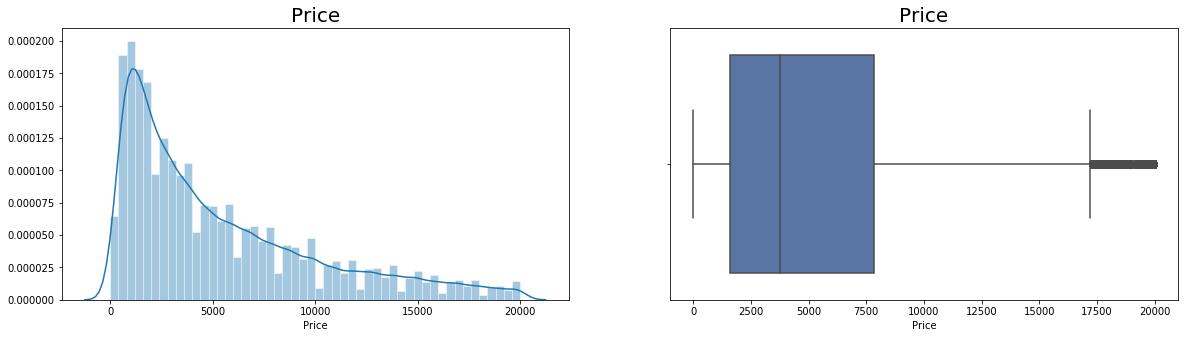

In [27]:
dist_and_box(df, 'Price')

In [28]:
df['Price'].describe()

count    227670.000000
mean       5356.900136
std        4742.248910
min           1.000000
25%        1600.000000
50%        3750.000000
75%        7850.000000
max       20000.000000
Name: Price, dtype: float64

Данные скошены вправо, среднее больше медианы.
 В правой части много выбросов, но такие цены на машину продавец вполне мог установить.

#### Посмотрим на корреляцию

###### [Таблица величины коэффициентов корреляции и силы связи (шкала Чеддока)](https://statpsy.ru/correlation/velicina/):
| Значение        | Интерпретация   |
| --------------- |----------------:|
| от 0 до 0,3     |   очень слабая  |
| от 0,3 до 0,5   |   слабая        |
| от 0, 5 до 0,7  |   средняя       |
| от 0,7 до 0, 9  |   высокая       |
| от 0,9 до 1     |   очень высокая |

In [29]:
df.corr()[['Price']].sort_values('Price')

,Price
Kilometer,-0.408460
NotRepaired,-0.209712
RegistrationMonth,0.011243
PostalCode,0.056780
Power,0.200849
RegistrationYear,0.562452
Price,1.000000


"Kilometer" имеет слабую отрицательную -0.401434 корреляцию
"RegistrationYear" имеет среднюю положительную 0.556149 корреляцию

In [30]:
#можно визуализировать, но выполняется ооочень долго
#sns.pairplot(data=df, hue = 'Price');

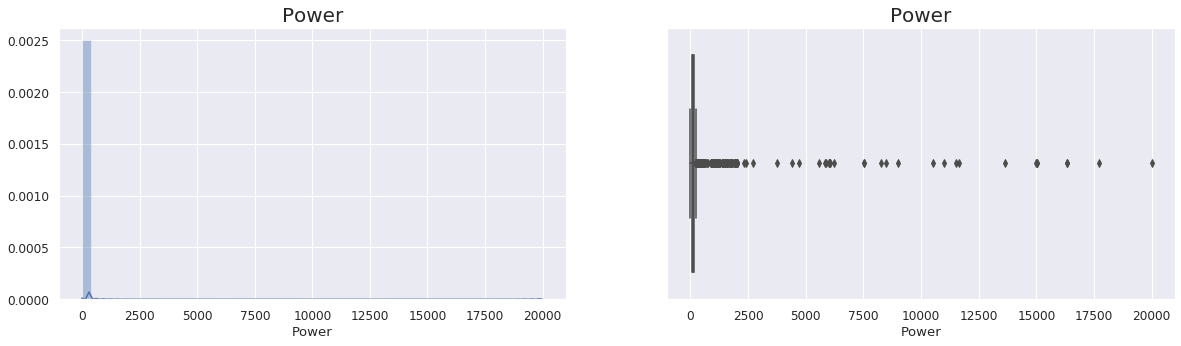

In [31]:
dist_and_box(df, 'Power')

In [32]:
df['Power'].describe()

count    227670.000000
mean        125.014991
std         133.519494
min           1.000000
25%          82.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

В данных мног выбросов, удалим все что больше 400 л.с.

In [33]:
df[(df['Power'] > 400) | (df['Power'] < 50)]['Power'].count()

3365

In [34]:
df = df[(df['Power'] < 400) & (df['Power'] > 50)]

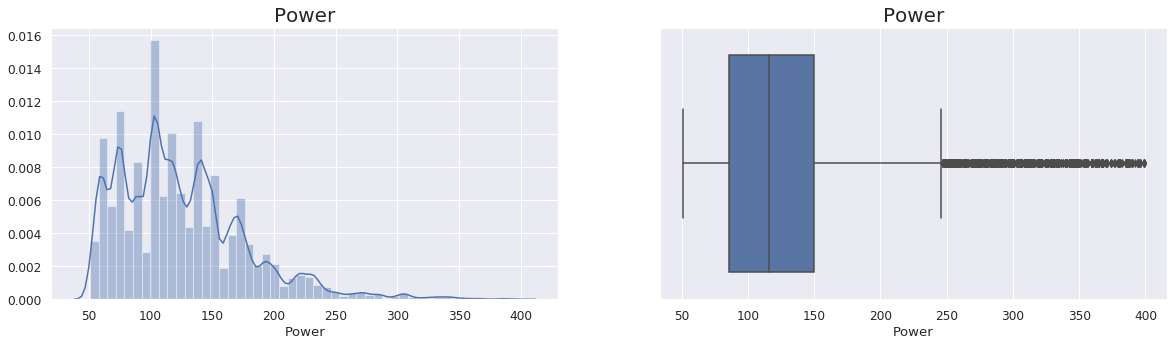

In [35]:
dist_and_box(df, 'Power')

In [36]:
df['Power'].describe()

count    221508.000000
mean        124.832390
std          51.499831
min          51.000000
25%          86.000000
50%         116.000000
75%         150.000000
max         399.000000
Name: Power, dtype: float64

### Теперь данные очищены. Подготовим признаки для обучения.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221508 entries, 3 to 354367
Data columns (total 12 columns):
Price                221508 non-null int64
VehicleType          221508 non-null object
RegistrationYear     221508 non-null int64
Gearbox              221508 non-null object
Power                221508 non-null int64
Model                221508 non-null object
Kilometer            221508 non-null int64
RegistrationMonth    221508 non-null int64
FuelType             221508 non-null object
Brand                221508 non-null object
NotRepaired          221508 non-null int64
PostalCode           221508 non-null int64
dtypes: int64(7), object(5)
memory usage: 22.0+ MB


Закодируем категориальные признаки техникой OHE. 

In [38]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
3,1500,2001,75,150000,6,0,91074,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,7,0,60437,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,650,1995,102,150000,10,1,33775,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2200,2004,109,150000,8,0,67112,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2000,2004,105,150000,12,0,96224,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Разделим выборки.

In [39]:
target_column = 'Price'
target = df[target_column]

In [40]:
features = df.drop([target_column], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Отмасштабируем числовые признаки

In [41]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

In [42]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

# 2. Обучение моделей

### LightGBM

In [43]:
import lightgbm as lgb

In [44]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

In [45]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [46]:
%%time
gbm_1 = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's rmse: 4573.62
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4439.87
[3]	valid_0's rmse: 4279.92
[4]	valid_0's rmse: 4129.88
[5]	valid_0's rmse: 3988.2
[6]	valid_0's rmse: 3856.64
[7]	valid_0's rmse: 3732.49
[8]	valid_0's rmse: 3616.61
[9]	valid_0's rmse: 3506.71
[10]	valid_0's rmse: 3405
[11]	valid_0's rmse: 3323.33
[12]	valid_0's rmse: 3230.83
[13]	valid_0's rmse: 3145.53
[14]	valid_0's rmse: 3077.71
[15]	valid_0's rmse: 3001.13
[16]	valid_0's rmse: 2929.59
[17]	valid_0's rmse: 2861.5
[18]	valid_0's rmse: 2798.32
[19]	valid_0's rmse: 2754.16
[20]	valid_0's rmse: 2697.41
[21]	valid_0's rmse: 2644.41
[22]	valid_0's rmse: 2594.97
[23]	valid_0's rmse: 2548.7
[24]	valid_0's rmse: 2505.94
[25]	valid_0's rmse: 2464.11
[26]	valid_0's rmse: 2424.92
[27]	valid_0's rmse: 2388.97
[28]	valid_0's rmse: 2355.29
[29]	valid_0's rmse: 2323.92
[30]	valid_0's rmse: 2293.67
[31]	valid_0's rmse: 2265.46
[32]	valid_0's rmse: 2239.14
[33]	valid_0's rmse: 2213.3

Точность на обучении RMSE: 2071.51  
Время обучения: 8.25 s

In [47]:
%%time
target_pred = gbm_1.predict(features_valid, num_iteration=gbm_1.best_iteration)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 2071.5134456633855
CPU times: user 521 ms, sys: 73.5 ms, total: 594 ms
Wall time: 597 ms


Точность предсказания RMSE: 2071.51  
Время предсказания: 505 ms

In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 60,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':20,
    'min_data_in_leaf':100
}

In [49]:
%%time
gbm_2 = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's rmse: 4567.21
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4425.62
[3]	valid_0's rmse: 4260.85
[4]	valid_0's rmse: 4105.7
[5]	valid_0's rmse: 3960.11
[6]	valid_0's rmse: 3824.12
[7]	valid_0's rmse: 3694.93
[8]	valid_0's rmse: 3574.67
[9]	valid_0's rmse: 3460.97
[10]	valid_0's rmse: 3354.81
[11]	valid_0's rmse: 3269.25
[12]	valid_0's rmse: 3173.84
[13]	valid_0's rmse: 3083.72
[14]	valid_0's rmse: 3012.52
[15]	valid_0's rmse: 2932.68
[16]	valid_0's rmse: 2858.98
[17]	valid_0's rmse: 2789.43
[18]	valid_0's rmse: 2724.5
[19]	valid_0's rmse: 2678.15
[20]	valid_0's rmse: 2619.05
[21]	valid_0's rmse: 2562.7
[22]	valid_0's rmse: 2511.3
[23]	valid_0's rmse: 2463.33
[24]	valid_0's rmse: 2418.17
[25]	valid_0's rmse: 2375.23
[26]	valid_0's rmse: 2335.63
[27]	valid_0's rmse: 2299.22
[28]	valid_0's rmse: 2264.04
[29]	valid_0's rmse: 2231.29
[30]	valid_0's rmse: 2200.99
[31]	valid_0's rmse: 2173.05
[32]	valid_0's rmse: 2146.53
[33]	valid_0's rmse: 2120

Изменил 'num_leaves': с 31 до 60, добавил 'max_depth':20 и 'min_data_in_leaf':100 и точность увеличилась.

Точность на обучении RMSE: 1982.97 (была 2071.51)    
Время обучения: 6.28 s (было 8.25 s)

In [50]:
%%time
target_pred = gbm_2.predict(features_valid, num_iteration=gbm_2.best_iteration)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 1982.9713046984687
CPU times: user 558 ms, sys: 52.2 ms, total: 610 ms
Wall time: 687 ms


Точность предсказания RMSE: 1982.97 (2071.51)  
Время предсказания: 557 ms (505 ms)

In [51]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':100,
    'min_data_in_leaf':100,
    'num_iterations': 100
}

In [52]:
%%time
gbm_3 = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's rmse: 4563.7
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4416.56
[3]	valid_0's rmse: 4248.11
[4]	valid_0's rmse: 4089.61
[5]	valid_0's rmse: 3940.45
[6]	valid_0's rmse: 3800.65
[7]	valid_0's rmse: 3669.79
[8]	valid_0's rmse: 3545.52
[9]	valid_0's rmse: 3429.73
[10]	valid_0's rmse: 3319.93
[11]	valid_0's rmse: 3231.47
[12]	valid_0's rmse: 3133.79
[13]	valid_0's rmse: 3042.37
[14]	valid_0's rmse: 2969.41
[15]	valid_0's rmse: 2888.13
[16]	valid_0's rmse: 2812.17
[17]	valid_0's rmse: 2739.87
[18]	valid_0's rmse: 2672.6
[19]	valid_0's rmse: 2625.03
[20]	valid_0's rmse: 2563.92
[21]	valid_0's rmse: 2505.42
[22]	valid_0's rmse: 2452.85
[23]	valid_0's rmse: 2403.98
[24]	valid_0's rmse: 2357.69
[25]	valid_0's rmse: 2315.58
[26]	valid_0's rmse: 2275.62
[27]	valid_0's rmse: 2237.32
[28]	valid_0's rmse: 2202.04
[29]	valid_0's rmse: 2168.71
[30]	valid_0's rmse: 2138.79
[31]	valid_0's rmse: 2111
[32]	valid_0's rmse: 2084.54
[33]	valid_0's rmse: 2058.

Изменил 'num_leaves': с 60 до 100, 'max_depth': с 20 до 100 и 'num_iterations': 100. Точность увеличилась.

Точность на обучении RMSE: 1634.57  (была 1982.97)    
Время обучения: 20.6 s (было 6.28 s)

In [53]:
%%time
target_pred = gbm_3.predict(features_valid, num_iteration=gbm_3.best_iteration)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 1634.5727548203192
CPU times: user 1.36 s, sys: 73.8 ms, total: 1.44 s
Wall time: 1.48 s


Точность предсказания RMSE: 1634.57 (1982.97)  
Время предсказания: 1.41 s (557 ms)

### CatBoost

In [54]:
from catboost import CatBoostRegressor

In [55]:
params = {'iterations':40, 
          'eval_metric':'RMSE', 
          'verbose': 4,
          'random_seed': 42
         }

In [56]:
cb_1 = CatBoostRegressor(**params)

In [57]:
%%time
cb_1.fit(features_train, target_train, eval_set=(features_valid, target_valid))

0:	learn: 4639.7142035	test: 4651.3164359	best: 4651.3164359 (0)	total: 75.4ms	remaining: 2.94s
4:	learn: 4281.9714394	test: 4293.0544759	best: 4293.0544759 (4)	total: 669ms	remaining: 4.68s
8:	learn: 3971.6316328	test: 3981.0911404	best: 3981.0911404 (8)	total: 1.26s	remaining: 4.35s
12:	learn: 3705.9645168	test: 3713.8892270	best: 3713.8892270 (12)	total: 1.87s	remaining: 3.88s
16:	learn: 3476.0464708	test: 3482.5307157	best: 3482.5307157 (16)	total: 2.46s	remaining: 3.33s
20:	learn: 3277.5389333	test: 3282.8689595	best: 3282.8689595 (20)	total: 3.05s	remaining: 2.76s
24:	learn: 3107.6635499	test: 3112.5431767	best: 3112.5431767 (24)	total: 3.64s	remaining: 2.19s
28:	learn: 2958.3272594	test: 2962.8491526	best: 2962.8491526 (28)	total: 4.15s	remaining: 1.57s
32:	learn: 2831.4360289	test: 2834.6081921	best: 2834.6081921 (32)	total: 4.74s	remaining: 1.01s
36:	learn: 2723.7822791	test: 2726.4911980	best: 2726.4911980 (36)	total: 5.33s	remaining: 432ms
39:	learn: 2651.6983139	test: 2653.

Точность на обучении RMSE: 2653.82  
Время обучения: 12.6 s

In [58]:
%%time
target_pred = cb_1.predict(features_valid)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 2653.818811566305
CPU times: user 24.5 ms, sys: 8.98 ms, total: 33.5 ms
Wall time: 15.8 ms


Точность предсказания RMSE: 2653.82   
Время предсказания: 15.2 ms

In [59]:
params = {'iterations':100, 
          'learning_rate': 0.05,
          'eval_metric':'RMSE', 
          'use_best_model': True,
          'verbose': 4,
          'random_seed': 42
         }

In [60]:
cb_2 = CatBoostRegressor(**params)

In [61]:
%%time
cb_2.fit(features_train, target_train, eval_set=(features_valid, target_valid))

0:	learn: 4574.3531322	test: 4585.6208540	best: 4585.6208540 (0)	total: 21ms	remaining: 2.08s
4:	learn: 4016.8773805	test: 4027.7951148	best: 4027.7951148 (4)	total: 616ms	remaining: 11.7s
8:	learn: 3579.5766698	test: 3587.5341387	best: 3587.5341387 (8)	total: 1.21s	remaining: 12.2s
12:	learn: 3237.0322784	test: 3243.0383523	best: 3243.0383523 (12)	total: 1.81s	remaining: 12.1s
16:	learn: 2975.2072147	test: 2979.0350402	best: 2979.0350402 (16)	total: 2.31s	remaining: 11.3s
20:	learn: 2768.5379390	test: 2770.9327188	best: 2770.9327188 (20)	total: 2.91s	remaining: 10.9s
24:	learn: 2608.5930647	test: 2610.2961897	best: 2610.2961897 (24)	total: 3.5s	remaining: 10.5s
28:	learn: 2483.4237928	test: 2484.3331997	best: 2484.3331997 (28)	total: 4.1s	remaining: 10s
32:	learn: 2387.8516847	test: 2387.5862945	best: 2387.5862945 (32)	total: 4.69s	remaining: 9.53s
36:	learn: 2307.9598737	test: 2306.0101024	best: 2306.0101024 (36)	total: 5.28s	remaining: 9s
40:	learn: 2245.8297930	test: 2243.1545207	b

Увеличил 'iterations': с 40 до 100, добавил 'learning_rate': 0.05 и 'use_best_model': True

Точность на обучении RMSE: 1890.58 (2653.82)  
Время обучения: 20.9 s (12.6 s)

In [62]:
%%time
target_pred = cb_2.predict(features_valid)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 1890.5832467377832
CPU times: user 28.4 ms, sys: 21.4 ms, total: 49.8 ms
Wall time: 18.8 ms


Точность предсказания RMSE: 1890.58 (2653.82)   
Время предсказания: 18.5 ms (15.2 ms)  

In [63]:
params = {'iterations':500, 
          'learning_rate': 0.02,
          'eval_metric':'RMSE', 
          'use_best_model': True,
          'verbose': 75,
          'bagging_temperature': 0.2,
          'depth':12,
          'od_type':'Iter',
          'metric_period': 75,
          'od_wait':100,
          'random_seed': 42
         }

In [64]:
cb_3 = CatBoostRegressor(**params)

In [65]:
%%time
cb_3.fit(features_train, target_train, eval_set=(features_valid, target_valid))

0:	learn: 4666.9228168	test: 4678.5960630	best: 4678.5960630 (0)	total: 426ms	remaining: 3m 32s
75:	learn: 2200.6650538	test: 2206.7192813	best: 2206.7192813 (75)	total: 29.2s	remaining: 2m 42s
150:	learn: 1800.7113397	test: 1810.7690497	best: 1810.7690497 (150)	total: 58.1s	remaining: 2m 14s
225:	learn: 1703.9941784	test: 1720.1646193	best: 1720.1646193 (225)	total: 1m 26s	remaining: 1m 45s
300:	learn: 1660.2619616	test: 1682.1994201	best: 1682.1994201 (300)	total: 1m 55s	remaining: 1m 16s
375:	learn: 1627.1656382	test: 1655.4759751	best: 1655.4759751 (375)	total: 2m 24s	remaining: 47.7s
450:	learn: 1600.1994665	test: 1634.6078775	best: 1634.6078775 (450)	total: 2m 53s	remaining: 18.8s
499:	learn: 1586.0906471	test: 1624.5227645	best: 1624.5227645 (499)	total: 3m 12s	remaining: 0us

bestTest = 1624.522765
bestIteration = 499

CPU times: user 2min 59s, sys: 17.4 s, total: 3min 17s
Wall time: 3min 19s


Увеличил 'iterations': с 100 до 500, изменил 'learning_rate': с 0.05 на 0.02. Добавил bagging_temperature': 0.2, 'depth':12, 'od_type':'Iter', 'metric_period': 75, od_wait':100

Точность на обучении RMSE: 1624.52 (1890.58)  
Время обучения: 3min 19s (20.9 s)

In [66]:
%%time
target_pred = cb_3.predict(features_valid)
print('RMSE:', mean_squared_error(target_valid, target_pred) ** 0.5)

RMSE: 1624.522764528419
CPU times: user 361 ms, sys: 46.2 ms, total: 407 ms
Wall time: 366 ms


Точность предсказания RMSE: 1624.52 (1890.58)   
Время предсказания: 396 ms (18.5 ms)  

### Собственная модель градиентного бустинга

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [68]:
def my_booster(features_data, target_data, n= 40, nu= 0.1, verbose = 10):
    features_df = features_data.copy()
    target_df = target_data.copy()
    trees = []
    features_df['y_pred'] = target_df.mean()
    features_df['residual'] = 0
    for i in range(n):
        features_df['residual'] = target_df - features_df['y_pred']
        tree = DecisionTreeRegressor(max_depth=1)
        tree.fit(features_df.drop(['residual','y_pred'],axis=1), features_df['residual'])
        features_df['y_pred'] += nu * tree.predict(features_df.drop(['residual','y_pred'],axis=1))
        trees.append(tree)
        if i % verbose == 0:
            print(f'{i} RMSE:', mean_squared_error(target_df, features_df['y_pred']) ** 0.5)
    print(f'{n} RMSE:', mean_squared_error(target_df, features_df['y_pred']) ** 0.5)
    return trees

In [69]:
%%time
trees_1 = my_booster(features_train, target_train)

0 RMSE: 4552.051855404981
10 RMSE: 3578.1242937402058
20 RMSE: 3125.4840961083114
30 RMSE: 2877.6234173137746
40 RMSE: 2744.52036533372
CPU times: user 25.6 s, sys: 14.1 s, total: 39.7 s
Wall time: 40.6 s


Точность на обучении RMSE: 2744.52  
Время обучения: 41.3 s

Проверим сделав предсказание.

In [70]:
def my_booster_pred(features_data, target_data, trees, nu = 0.1):
    features_val = features_data.copy()
    target_val = target_data.copy()
    features_val['y_pred'] = target_val.mean()
    features_val['residual'] = 0
    for tree in trees:
        features_val['y_pred'] += nu * tree.predict(features_val.drop(['residual','y_pred'],axis=1))
    print(f'RMSE:', mean_squared_error(target_val, features_val['y_pred']) ** 0.5)

In [71]:
%%time
my_booster_pred(features_valid, target_valid, trees_1)

RMSE: 2746.6249707895286
CPU times: user 2.5 s, sys: 2.02 s, total: 4.52 s
Wall time: 4.63 s


Точность предсказания RMSE: 2746.625   
Время предсказания: 4.72 s

In [72]:
%%time
trees_2 = my_booster(features_train, target_train, 60, 0.05, verbose=20)

0 RMSE: 4643.780531479206
20 RMSE: 3626.1642030921353
40 RMSE: 3159.119370660326
60 RMSE: 2910.792139456159
CPU times: user 38.4 s, sys: 21.1 s, total: 59.5 s
Wall time: 1min


Точность на обучении RMSE: 2910.79 (2746.62)   
Время обучения: 1min 1s (41.3 s)

In [73]:
%%time
my_booster_pred(features_valid, target_valid, trees_2)

RMSE: 3090.9757427679137
CPU times: user 3.81 s, sys: 2.93 s, total: 6.74 s
Wall time: 6.9 s


Похоже модель переобучилась.

Точность предсказания RMSE: 3090.97 (2746.625)   
Время предсказания: 6.99 s

In [74]:
%%time
trees_3 = my_booster(features_train, target_train, 100, 0.05, verbose=20)

0 RMSE: 4643.780531479206
20 RMSE: 3626.1642030921066
40 RMSE: 3159.1193706603126
60 RMSE: 2901.091981954808
80 RMSE: 2749.5079157395603
100 RMSE: 2654.1831929415666
CPU times: user 1min 4s, sys: 34.5 s, total: 1min 39s
Wall time: 1min 40s


Точность на обучении RMSE: 2654.18 (2744.52)  
Время обучения: 1min 42s (41.3 s)

In [75]:
%%time
my_booster_pred(features_valid, target_valid, trees_3)

RMSE: 3486.9395484593115
CPU times: user 6.23 s, sys: 4.94 s, total: 11.2 s
Wall time: 11.3 s


Тоже переобучилась.

Точность предсказания RMSE: 3486.93 (2746.625)   
Время предсказания: 11.3 s

# 3. Анализ моделей

#### Метрики полученных результатов  
    
| Модели         | RMSE на обучении | RMSE на предсказании  | Время обучения | Время предсказания |
| ---------------|-----------------:|----------------------:|---------------:|-------------------:|
| Lightgbm_1     |          2071.50 |               2071.51 |         8.25 s |           505.0 ms |
| **Lightgbm_2** |          1982.97 |               1982.97 |     **6.28 s** |           688.0 ms |
| Lightgbm_3     |          1634.57 |               1634.57 |         20.6 s |          1500.0 ms |
| **CatBoost_1** |          2653.82 |               2653.82 |         12.6 s |        **15.2 ms** |
| CatBoost_2     |          1890.58 |               1890.58 |         20.9 s |            18.5 ms |
| **CatBoost_3** |      **1624.52** |           **1624.52** |     *3min 19s* |             396 ms |
| My_booster_1   |          2744.52 |               2746.62 |       1min 42s |          4720.0 ms |
| My_booster_2   |        *2910.79* |               3090.97 |        1min 1s |          6990.0 ms |
| My_booster_3   |          2654.18 |             *3486.93* |       1min 42s |       *11300.0 ms* |

Данные для этой работы были очищены, проанализированы и подготовлены к
дальнейшему обучения. Категориальные признаки кодировались техникой
One_Hot_Encoding (OHE), числовые были приведены к одному масштабу.
 После чего было произведено обучения на трех моделях градиентного
 бустинга Lightgbm, CatBoost, Собственная модель с тремя разными наборами гиперпараметров.
  
Модель CatBoost_3 самая точная (1624.52), но обучается дольше
остальных (3min 19s) зато предсказывает быстрее всех трёх Lightgbm,
за 396 ms. Быстрее всех обучалась модель Lightgbm_2.